<a href="https://colab.research.google.com/github/dtmeyers/Soccer-Data-Analysis/blob/main/CalcWinPercentage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To use C++ code in python, we have to build a class in C++ and then export it as a library that python can read. [This](https://www.auctoris.co.uk/2017/04/29/calling-c-classes-from-python-with-ctypes/) article makes that library.so and then uses ctypes when calling the class and passing it variables in python. [This](https://iq.opengenus.org/create-shared-library-in-cpp/) article has an alternate way of creating the library that is much simpler.

The way I structures this notebook to do soccer analysis is to write the file in a code cell here, then import it from the following code cell (stored in Drive). The class takes in 4 variables upon creation: home and away team atk and def ratings. Upon construction, the class calculates home and away win percentages, which can each be returned with a function call.

To test this, I can use values from the World Cup simulator, which will make the declarations in python trivial and avoid a significant amount of data manipulation.

In [ ]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %shell  %store  %sx  %system  %tb  %tensorflow_version  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%bigquery  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl 

In [1]:
%%writefile CalcWinPercentage.cpp

#include <iostream>
#include <cstring>
#include <cstdlib>
#include <string>
#include <cmath>

using namespace std;

class CalcWinPercentage {
    public:
        CalcWinPercentage(double homeAtk, double homeDef, double awayAtk, double awayDef);
        void calc(double homeAtk, double homeDef, double awayAtk, double awayDef);
        void reset() {
            homewin = 0.0;
            awaywin = 0.0;
        }
        double homewinpercentage() {return homewin;}
        double awaywinpercentage() {return awaywin;}
        int factorial (int num);
        
        const float avgGoals = 1.56;
 
    private:
        double homewin, awaywin;
};

CalcWinPercentage::CalcWinPercentage(double homeAtk, double homeDef, double awayAtk, double awayDef) {
    homewin = 0;
    awaywin = 0;

    int i, j;
    float scoreChance, homeExpGoals, awayExpGoals;
 
    // this is broken because the formula is based on percentages, so 1 - x is positive
    homeExpGoals = ((homeAtk * awayDef) / avgGoals) / ((homeAtk * awayDef) / avgGoals + (avgGoals/ (homeAtk * awayDef)));
    awayExpGoals = ((awayAtk * homeDef) / avgGoals) / ((awayAtk * homeDef) / avgGoals + ((1 - awayAtk) * (1 - homeDef) / (1 - avgGoals)));
 
    for (i = 0; i < 8; i++) {
        for (j = 0; j < 8; j++) {
            scoreChance = pow(homeExpGoals, i) * pow(awayExpGoals, j) * exp(-(homeExpGoals + awayExpGoals)) / (factorial(i) * factorial(j));
            if (i > j) {
                homewin += scoreChance;
            }
            if (j > i) {
                awaywin += scoreChance;
            }
        }
    }

    homewin = homeExpGoals;
    awaywin = awayExpGoals;
}

void CalcWinPercentage::calc(double homeAtk, double homeDef, double awayAtk, double awayDef) {
    int i, j;
    float scoreChance;
    homewin = 0;
    awaywin = 4.5;
 
}

int CalcWinPercentage::factorial (int num) {
    int result = 1;
    if (num > 0) {
        for (int i = num; i > 1; i--) {
            result *= i;
        }
    }
    return result;
}

// Define C functions for the C++ class that can be accessed by ctypes

extern "C"
{
    CalcWinPercentage* CWP_new(double ha, double hd, double aa, double ad) {return new CalcWinPercentage(ha, hd, aa, ad);}
    void CWP_calc(CalcWinPercentage* cwp, double ha, double hd, double aa, double ad) {cwp->calc(ha, hd, aa, ad);}
    void CWP_reset(CalcWinPercentage* cwp) {cwp->reset();}
    double CWP_homewinpercentage(CalcWinPercentage* cwp) {return cwp->homewinpercentage();}
    double CWP_awaywinpercentage(CalcWinPercentage* cwp) {return cwp->awaywinpercentage();}
    int CWP_factorial(CalcWinPercentage* cwp, int num) {return cwp->factorial(num);}
}

Writing CalcWinPercentage.cpp


In [ ]:
!rm libCalcWinPercentage.so
!rm CalcWinPercentage.o
!ls -l

rm: cannot remove 'libCalcWinPercentage.so': No such file or directory
rm: cannot remove 'CalcWinPercentage.o': No such file or directory
total 12
-rw-r--r-- 1 root root 2649 Jul 10 03:14 CalcWinPercentage.cpp
drwx------ 5 root root 4096 Jul 10 03:08 drive
drwxr-xr-x 1 root root 4096 Jul  6 13:22 sample_data


In [2]:
!g++ -c -fPIC CalcWinPercentage.cpp -o CalcWinPercentage.o
!gcc -shared -o libCalcWinPercentage.so CalcWinPercentage.o
!ls -l

total 36
-rw-r--r-- 1 root root  2660 Jul 13 01:57 CalcWinPercentage.cpp
-rw-r--r-- 1 root root  7952 Jul 13 01:57 CalcWinPercentage.o
drwx------ 5 root root  4096 Jul 13 01:57 drive
-rwxr-xr-x 1 root root 13608 Jul 13 01:57 libCalcWinPercentage.so
drwxr-xr-x 1 root root  4096 Jul  6 13:22 sample_data


Index(['season', 'date', 'league_id', 'league', 'team1', 'team2', 'spi1',
       'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2',
       'importance1', 'importance2', 'score1', 'score2', 'xg1', 'xg2', 'nsxg1',
       'nsxg2', 'adj_score1', 'adj_score2'],
      dtype='object')

 My model correlation


AttributeError: ignored

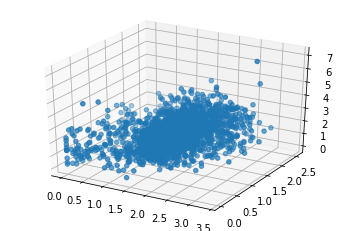

In [47]:
from mpl_toolkits import mplot3d
import ctypes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

lib = ctypes.cdll.LoadLibrary('/content/libCalcWinPercentage.so')

class CalcWinPercentage:
  def __init__(self, ha, hd, aa, ad):
    lib.CWP_new.argtypes = [ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]
    lib.CWP_new.restype = ctypes.c_void_p

    lib.CWP_calc.argtypes = [ctypes.c_void_p, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]
    lib.CWP_calc.restype = ctypes.c_void_p

    lib.CWP_reset.argtypes = [ctypes.c_void_p]
    lib.CWP_reset.restype = ctypes.c_void_p

    lib.CWP_homewinpercentage.argtypes = [ctypes.c_void_p]
    lib.CWP_homewinpercentage.restype = ctypes.c_double

    lib.CWP_awaywinpercentage.argtypes = [ctypes.c_void_p]
    lib.CWP_awaywinpercentage.restype = ctypes.c_double

    lib.CWP_factorial.argtypes = [ctypes.c_void_p, ctypes.c_int]
    lib.CWP_factorial.restype = ctypes.c_int

    self.obj = lib.CWP_new(ha, hd, aa, ad)

  def calc(self, ha, hd, aa, ad):
    lib.CWP_calc(self.obj, ha, hd, aa, ad)

  def reset(self):
    lib.CWP_reset(self.obj)

  def homewinpercentage(self):
    return lib.CWP_homewinpercentage(self.obj)

  def awaywinpercentage(self):
    return lib.CWP_awaywinpercentage(self.obj)

# from lib import CalcWinPercentage

# Code block will analyze EPL data
# Load the data into variables
spi_global_ranking = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_global_rankings.csv')
spi_matches = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches.csv')
spi_matches_latest = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches_latest.csv')

EPL_match_odds_2122 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2021 2022.csv')
EPL_match_odds_2021 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2020 2021.csv')
EPL_match_odds_1920 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2019 2020.csv')
EPL_match_odds_1819 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2018 2019.csv')
EPL_match_odds_1718 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2017 2018.csv')
EPL_match_odds_1617 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2016 2017.csv')

# This section stores the data I want to use regarding betting markets in a new dataframe
keep_cols = ['HomeTeam', 'AwayTeam', 'B365H', 'B365A', 'B365D', 'FTR', 'HTR']
EPL_match_odds = EPL_match_odds_1617[keep_cols].sort_values(['HomeTeam', 'AwayTeam'])
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_1718[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_1819[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_1920[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_2021[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_2122[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))

# This section converts the data into usable forms
# Converting between decimal odds and implied probability is just y = 1/x
EPL_match_odds['B365A'] = EPL_match_odds['B365A'].apply(lambda x: 1/x)
EPL_match_odds['B365D'] = EPL_match_odds['B365D'].apply(lambda x: 1/x)
EPL_match_odds['B365H'] = EPL_match_odds['B365H'].apply(lambda x: 1/x)

spi_matches_EPL = spi_matches[spi_matches['league'] == 'Barclays Premier League']
spi_matches_EPL = spi_matches_EPL.replace(to_replace='AFC Bournemouth', value='Bournemouth').sort_values(['season', 'team1', 'team2'])

# This block will load the data I'm using into a new dataframe to make it easier to manipulate
# The odds in the odds_comparison dataframe represent the difference between SPI match
# probability and the line offered at Bet365. Positive numbers represent +EV
home_odds = np.array(spi_matches_EPL['prob1']) - np.array(EPL_match_odds['B365H'])
home_odds = [round(x*100, 2) for x in home_odds]

away_odds = np.array(spi_matches_EPL['prob2']) - np.array(EPL_match_odds['B365A'])
away_odds = [round(x*100, 2) for x in away_odds]

draw_odds = np.array(spi_matches_EPL['probtie']) - np.array(EPL_match_odds['B365D'])
draw_odds = [round(x*100, 2) for x in draw_odds]

odds_comparison = pd.DataFrame({'Season': spi_matches_EPL['season'],
                                'Home Team': spi_matches_EPL['team1'],
                                'Away Team': spi_matches_EPL['team2'],
                                'Home Edge': home_odds,
                                'Away Edge': away_odds,
                                'Draw Edge': draw_odds,
                                'Result': np.array(EPL_match_odds['FTR'])})

print(spi_matches_EPL.columns)
keep_cols = ['date', 'team1', 'team2', 'proj_score1', 'proj_score2', 'score1', 'score2', 'xg1', 'xg2']
test_data = spi_matches_EPL[spi_matches_EPL['season'] > 2017]
test_data = spi_matches_EPL[keep_cols].sort_values(['date'])
test_data = test_data.dropna()

# Arrays to build the DataFrame
date = [np.array(test_data['date'])[x+10] for x in range(len(test_data) - 10)]
hometeam = [np.array(test_data['team1'])[x+10] for x in range(len(test_data) - 10)]
home_goals = [np.array(test_data['xg1'])[x+10] for x in range(len(test_data) - 10)]
away_goals = [np.array(test_data['xg2'])[x+10] for x in range(len(test_data) - 10)]
awayteam = [np.array(test_data['team2'])[x+10] for x in range(len(test_data) - 10)]

# Object to handle data manipulation; initialized to create ratings
class CalcTeamRatings:
  def __init__(self, home, away, date, df):
    self.home = home
    self.date = date
    self.away = away
    self.df = df[df['date'] < self.date].sort_values(['date'])
    self.df = self.df.dropna()
    self.home_df = self.df[self.df['team1'] == self.home]
    self.home_df = self.home_df.tail(10)
    self.away_df = self.df[self.df['team2'] == self.away]
    self.away_df = self.away_df.tail(10)
  def rollingAvgXG(self):
    return self.home_df['xg1'].sum()/10
  def rollingAvgXGA(self):
    return self.home_df['xg2'].sum()/10
  def away_rollingAvgXG(self):
    return self.away_df['xg2'].sum()/10
  def away_rollingAvgXGA(self):
    return self.away_df['xg1'].sum()/10
  def predict_home_goals(self):
    # I can't just calculate the away teams historic xG as input into the model
    # because it doesn't correlate at all with the home teams goals scored
    # because they don't always play each other! So...the second input has to be
    # the def rating for the home teams opponent in each match
    team_ratings_df = self.df[self.df['team1'] == self.home]
    team_ratings_input = np.array(team_ratings_df[['team2', 'date']])
    team_ratings = [CalcTeamRatings(self.home, team_ratings_input[x][0], team_ratings_input[x][1], self.df) for x in range(len(team_ratings_input))]
    team_ratings = np.array(team_ratings)
    input_array1 = [team_ratings[x].rollingAvgXG() for x in range(len(team_ratings))]
    input_array1 = np.array(input_array1)
    input_array2 = [team_ratings[x].away_rollingAvgXGA() for x in range(len(team_ratings))]
    input_array2 = np.array(input_array2)
    input_data = [[input_array1[x], input_array2[x]] for x in range(len(team_ratings))]
    input_data = np.array(input_data)
    
    output_data = [np.array(team_ratings_df['xg1'])[x] for x in range(len(team_ratings_df))]
    output_data = np.array(output_data)

    predict_input1 = self.home_df['xg1'].sum()/10
    predict_input2 = self.away_df['xg1'].sum()/10
    if input_data.size == 0:
      return 0

    model = LinearRegression().fit(input_data, output_data)
    return model.predict(np.array([predict_input1, predict_input2]).reshape(1, -1))

def CalcExpectedGoals(team1_atk, team2_def, lg_avg):
  return ((team1_atk * .7) + (team2_def * .5) - (.3 * lg_avg))

lg_avg_home = test_data['xg1'].sum()/len(test_data)
lg_avg_away = test_data['xg2'].sum()/len(test_data)

game_data = pd.DataFrame({'Date': np.array(date),
                          'Home Team': np.array(hometeam),
                          'Away Team': np.array(awayteam),
                          'Home Goals': np.array(home_goals),
                          'Away Goals': np.array(away_goals)})
game_data['Object'] = [CalcTeamRatings(game_data['Home Team'][x], game_data['Away Team'][x], game_data['Date'][x], spi_matches_EPL) for x in range(len(game_data))]
game_data['Home Atk'] = [game_data['Object'][x].rollingAvgXG() for x in range(len(game_data))]
game_data['Home Def'] = [game_data['Object'][x].rollingAvgXGA() for x in range(len(game_data))]
game_data['Away Atk'] = [game_data['Object'][x].away_rollingAvgXG() for x in range(len(game_data))]
game_data['Away Def'] = [game_data['Object'][x].away_rollingAvgXGA() for x in range(len(game_data))]
game_data['Home xG'] = [CalcExpectedGoals(np.array(game_data['Home Atk'])[x], np.array(game_data['Away Def'])[x], lg_avg_home) for x in range(len(game_data))]
game_data['Away xG'] = [CalcExpectedGoals(np.array(game_data['Away Atk'])[x], np.array(game_data['Home Def'])[x], lg_avg_away) for x in range(len(game_data))]
game_data['Model Home Goals'] = [np.array(game_data['Object'])[x].predict_home_goals() for x in range(len(game_data))]

game_data = game_data.dropna()

fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = np.array(game_data['Home Atk'])
ydata = np.array(game_data['Away Def'])
zdata = np.array(game_data['Home Goals'])

ax.scatter3D(xdata, ydata, zdata)

print("\n", "My model correlation")
print(pd.Series(game_data['Model Home Goals']).corr(game_data['Home Goals']))
print(game_data['Away xG'].corr(game_data['Away Goals']))

print("\n", "SPI correlation")
print(test_data['proj_score1'].corr(test_data['xg1']))
print(test_data['proj_score2'].corr(test_data['xg2']))

print("\n", "League Average Goals Scored")
print(lg_avg_home)
print(lg_avg_away)
print(" ")

input_data = [[xdata[x], ydata[x]] for x in range(len(xdata))]
input_data = np.array(input_data)

print(" ")

model = LinearRegression().fit(input_data, zdata)
r_sq = model.score(input_data, zdata)
print(f"R Squared: {r_sq}\n")
print(f"Intercept: {model.intercept_}\n")
print(f"Coefficients: {model.coef_}\n")

# try taking a team's total xg and xga per game from the data set (I know, it's way too big a sample)
# that should provide a reasonable-ish baseline to test
# add them to the dataframe in new columns, and play

# Test that the library is working
#cwp = CalcWinPercentage(4, 5, 6.7, 7)
#print(cwp.awaywinpercentage())
#print(cwp.homewinpercentage())
#cwp.reset()
#print(cwp.awaywinpercentage())

At this point, my C++ code works in the python script. I'll use it to add a column to a dataframe that has many rows to verify speed.

Research that needs to be done: figuring out how to calculate expected goals scored given the home teams attack rating and the away teams defensive rating. [This article](http://blog.philbirnbaum.com/2016/01/when-log5-does-and-doesnt-work.html) is an excellent primer on the log 5 method, which Bill James proposed as a way to calculate win percentages in baseball given a team's underlying talent. This needs to be tested more for it's application to soccer.